In [1]:
import pandas as pd
import numpy as np

test_books = pd.read_csv('local_data/book_test.csv')
test_mails = pd.read_csv('local_data/mail_test.csv')
test_blogs = pd.read_csv('local_data/blog_test.csv')

In [2]:
# Utilities
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from random import shuffle

TOKENIZER = AutoTokenizer.from_pretrained('roberta-large')

def embed(model, texts):
    tokenized_texts = TOKENIZER(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    embedding = model(tokenized_texts.input_ids.to(model.device),
                      tokenized_texts.attention_mask.to(model.device),
                      )
    return embedding

In [3]:
model_zoo = {'all': 'model/final_2022-06-21_12-22-26_lstm_books+mails+blogs.ckpt',
            'books': 'model/final_2022-06-28_07-55-16_lstm_books.ckpt',
            'mails': 'model/final_2022-06-27_08-14-08_lstm_mails.ckpt',
            'blogs': 'model/final_2022-06-15_08-10-17_lstm_blogs.ckpt',
            }
data_zoo = {'all': test_books.append(test_mails).append(test_blogs),
            'books': test_books,
            'mails': test_mails,
            'blogs': test_blogs,
            }

/tmp/ipykernel_213420/3411237818.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_zoo = {'all': test_books.append(test_mails).append(test_blogs),


In [4]:
from model_experimental import ContrastiveLSTMTransformer

DEVICE = 1
model = ContrastiveLSTMTransformer.load_from_checkpoint(checkpoint_path=model_zoo['all']).cuda(DEVICE)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [5]:
embeddings = []

for book_idx, book_df in tqdm(data_zoo['books'].groupby('title')):
    with torch.no_grad():
        batch = TOKENIZER(book_df.decoded_text.tolist(), return_tensors='pt', padding='max_length', max_length=512, truncation=True)
        embedding = model(batch.input_ids[:128].cuda(model.device), batch.attention_mask[:128].cuda(model.device)).mean(0)
        embeddings.append(embedding.cpu())
    
embeddings = torch.stack(embeddings, 0)

  0%|          | 0/244 [00:00<?, ?it/s]

In [6]:
import re

grouped_df = data_zoo['books'].groupby('title')
authors = grouped_df.apply(lambda x: x.iloc[0]).author.tolist()
books =  grouped_df.apply(lambda x: x.iloc[0]).index.tolist()
years =  grouped_df.apply(lambda x: x.iloc[0]).authoryearofdeath.tolist()
subjects =  grouped_df.apply(lambda x: x.iloc[0]).subjects.apply(lambda x: re.findall(r'[\"\'](.*?)[\"\']', x)).tolist()

embedding_dataset = pd.DataFrame({'book': books, 'embedding': [embed for embed in embeddings.numpy()], 'year_of_death': years, 'subjects': subjects, 'author': authors})

In [7]:
search_terms = {'fiction', 'history', 'biography', 'poetry', 'essay'}

embedding_dataset['simple_subject'] = embedding_dataset.subjects.apply(lambda x: list(set(term for term in search_terms for subject in x if term in subject.lower())))

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

def plot_df(df):
    %matplotlib inline

    plt.figure(figsize=(7,4.5))
    
    sns.set_style("whitegrid")

    ax = sns.scatterplot(x='umap_0', # Horizontal axis
               y='umap_1', # Vertical axis
               data=df, # Data source
               hue='Type',
               s=50,
               palette="Spectral") # size and dimension

    #plt.title('NLI')
    # Set x-axis label
    plt.xlabel('Component 1')
    # Set y-axis label
    plt.ylabel('Component 2')
    legend = plt.legend(fancybox = True)
    legend.set_title('Book type')

    frame = legend.get_frame() #sets up for color, edge, and transparency
    frame.set_facecolor('#b4aeae') #color of legend
    frame.set_edgecolor('black') #edge color of legend
    frame.set_alpha(1) #deals with transparency
    
    return plt
    
def make_plot(data, n_neighbors, min_dist):
    scaler = StandardScaler()
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine',
                        random_state=2)
    embeddings_train = data.embedding.tolist()
    scaled_embs = scaler.fit_transform(embeddings_train)
    reduced_embs = reducer.fit_transform(scaled_embs)
    
    df = pd.DataFrame({'umap_0': reduced_embs[:,0],
                   'umap_1': reduced_embs[:,1],
                   'Type': data.simple_subject.tolist(),
                  })
    print(f'n_neighbors:{n_neighbors}, min_dist:{min_dist}')
    
    return plot_df(df)

neighbors = [3, 5, 10, 20]
min_dist = [.1, .25, .5, .75, .9, .99]
params = [{'n_neighbors': nn, 'min_dist': md} for nn in neighbors for md in min_dist]
candidates = embedding_dataset[embedding_dataset.simple_subject.apply(len) > 0]
candidates.simple_subject = candidates.simple_subject.apply(str).replace({"['poetry']": 'Poetry',
                                  "['history']": 'History',
                                  "['fiction']": 'Fiction',
                                  "['essay']": 'Essay',
                                  "['biography']": 'Biography',
                                  "['biography', 'history']": 'Biography & History',
                                  "['history', 'fiction']": 'Fiction & History',
                                  "['history', 'poetry']": 'Poetry & History',
                                  "['poetry', 'history']": 'Poetry & History',
                                  "['essay', 'poetry']": 'Poetry & Essay',
                                  "['poetry', 'essay']": 'Poetry & Essay',
                                  "['fiction', 'history']": 'Fiction & History',
                                  })
candidates = candidates.groupby('author').apply(lambda x: x.iloc[:5])
#[make_plot(candidates, **kwparams) for kwparams in params]

/tmp/ipykernel_165021/2921341137.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates.simple_subject = candidates.simple_subject.apply(str).replace({"['poetry']": 'Poetry',


n_neighbors:10, min_dist:0.1


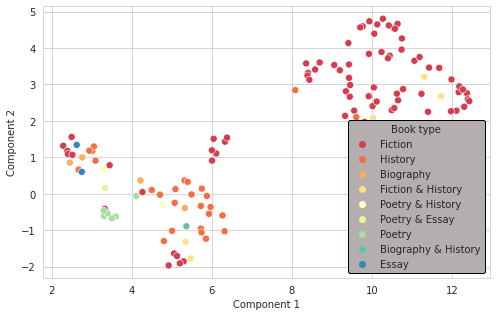

In [22]:
plt = make_plot(candidates, n_neighbors=10, min_dist=.1)
plt.tight_layout()
plt.savefig("figures/books_umap.pdf", dpi=1000)

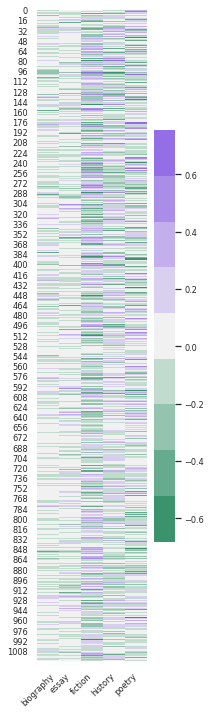

In [11]:
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
#numpy.cov(np.stack(embedding_dataset.embedding.tolist()), y=None, rowvar=False)
candidates = embedding_dataset[embedding_dataset.simple_subject.apply(len) > 0]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(candidates.simple_subject.tolist())
x = np.stack(candidates.embedding.tolist())

corr = np.zeros((x.shape[-1], y.shape[-1]))
sns.set(font_scale = .75)

for i, x_var in enumerate(x.T):
    for j, y_var in enumerate(y.T):
        corr[i, j] = np.corrcoef(x_var, y_var)[1, 0]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(3, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, cmap=cmap, square=False, linewidths=0)#, cbar_kws={"shrink": .5})
ax.set_xticks(range(len(mlb.classes_)), mlb.classes_, rotation = 45)
f.tight_layout()
plt.savefig("figures/books_correlation.pdf", dpi=1000)

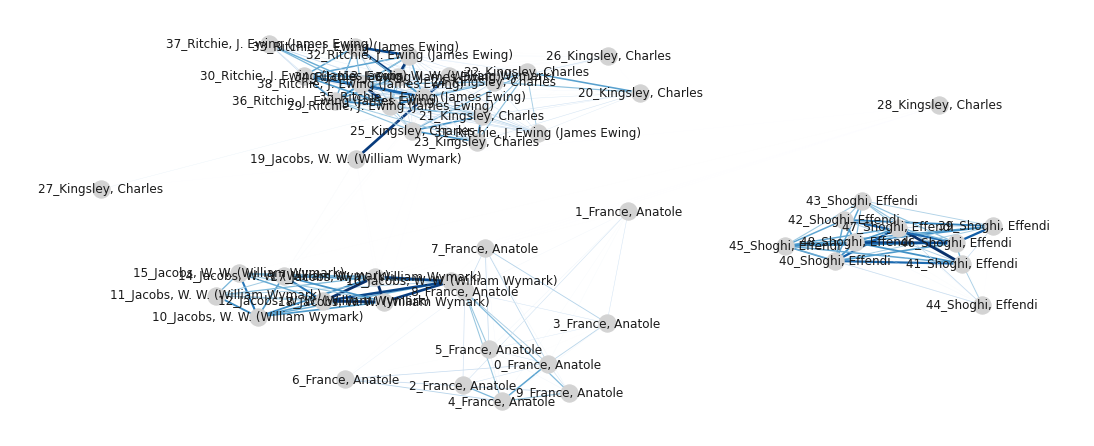

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

candidates = set(embedding_dataset.author.value_counts()[:5].index.tolist())
dup_dataset = embedding_dataset[embedding_dataset.author.isin(candidates)].groupby('author').apply(lambda x: x.iloc[:10])
dup_dataset

#G = nx.Graph(edges = [(1, 2, 1), (2, 3, 2), (3, 4, 1), (4, 5, 2)]
th = .6
cs = cosine_similarity(dup_dataset.embedding.tolist())
cs = (cs - th) / (1 - th)
cs[cs<0] = 0
cs *= np.tri(*cs.shape)
np.fill_diagonal(cs, 0)

col_row = dup_dataset.author.tolist()
G = nx.to_networkx_graph(cs**2)
G = nx.relabel_nodes(G, {k: f'{k}_{v}' for k, v in zip(range(len(col_row)),col_row)})
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

plt.figure(figsize=(15,6))
pos = nx.spring_layout(G, k=0.7, iterations=70)
#pos = nx.spectral_layout(G, scale=1e-5)
nx.draw(G, pos, node_size=300, node_color = 'lightgrey', edge_color=weights,
        width=3*np.array(weights),
        with_labels=True,
        edge_cmap=plt.cm.Blues)
#nx.draw_networkx_edge_labels(G, pos)
#plt.show()
plt.savefig("figures/books_graph.pdf", dpi=1000)

In [13]:
y = data_zoo['blogs'].groupby('id').apply(lambda x: x.iloc[0])
print(y.age.value_counts())
print(y.gender.value_counts())
print(y.topic.value_counts())

17    235
16    211
23    208
24    205
15    170
26    155
25    155
14    116
27    112
13     58
34     46
33     42
35     30
36     27
37     23
41     20
38     15
40     14
39     14
43     13
45     11
44     10
42      9
46      8
47      8
48      5
Name: age, dtype: int64
male      976
female    944
Name: gender, dtype: int64
indUnk                     667
Student                    497
Technology                 108
Education                   97
Arts                        73
Communications-Media        51
Non-Profit                  35
Internet                    34
Engineering                 28
Consulting                  23
Government                  21
Advertising                 19
Law                         18
BusinessServices            18
Accounting                  17
Publishing                  17
Science                     16
Telecommunications          15
Military                    14
Religion                    12
Tourism                     12
Banking   

In [14]:
data_zoo['blogs']

,id,pretokenized_text,decoded_text,age,topic,gender
0,blog_1000,"[0, 2387, 128, 9484, 108, 300, 11, 63, 78, 103...",<s>My 'band' got in its first fight tonight. m...,16,Student,male
1,blog_1000,"[5, 6613, 489, 110, 5567, 7, 5, 1255, 132, 4, ...",the soil keep your ear to the ground 2. Nirva...,16,Student,male
2,blog_1000,"[8419, 28989, 102, 21, 269, 205, 11, 24, 4, 98...",travolta was really good in it. so was samuel...,16,Student,male
3,blog_1000,"[4, 947, 282, 39596, 131, 98, 52, 439, 89, 8, ...",.&nbsp; so we went there and went out to eat a...,16,Student,male
4,blog_1000,"[282, 39596, 131, 947, 282, 39596, 131, 947, 2...",nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp...,16,Student,male
...,...,...,...,...,...,...
38765,blog_9938,"[4, 280, 18, 45, 205, 142, 6, 71, 70, 6, 42, 1...",". That's not good because, after all, this sit...",33,indUnk,male
38766,blog_9938,"[5919, 6, 6966, 8, 2254, 28852, 13295, 23668, ...","tennis, swim and enjoy nightly bonfires on th...",33,indUnk,male
38767,blog_9938,"[10631, 8, 13404, 95, 7, 1649, 383, 66, 734, 5...",Mom and Dad just to check things out...to see...,33,indUnk,male
38768,blog_9938,"[9, 5761, 38497, 108, 1437, 361, 35, 541, 2784...",of Forest Fires' 9:30 PM Break for secret ...,33,indUnk,male


In [5]:
embeddings = []

for book_idx, book_df in tqdm(data_zoo['blogs'].groupby('id')):
    with torch.no_grad():
        batch = TOKENIZER(book_df.decoded_text.tolist(), return_tensors='pt', padding=True, max_length=512, truncation=True)
        embedding = model(batch.input_ids[:128].cuda(model.device), batch.attention_mask[:128].cuda(model.device)).mean(0)
        embeddings.append(embedding.cpu())
    
embeddings = torch.stack(embeddings, 0)

  0%|          | 0/1920 [00:00<?, ?it/s]

In [ ]:
import re

grouped_df = data_zoo['blogs'].groupby('id')
age = grouped_df.apply(lambda x: x.iloc[0]).age.tolist()
topic =  grouped_df.apply(lambda x: x.iloc[0]).topic.tolist()
gender =  grouped_df.apply(lambda x: x.iloc[0]).gender.tolist()
author_id =  grouped_df.apply(lambda x: x.iloc[0]).index.tolist()
sample_text =  grouped_df.apply(lambda x: x.iloc[1]).decoded_text.tolist()

embedding_dataset = pd.DataFrame({'age': age, 'embedding': [embed for embed in embeddings.numpy()], 'topic': topic, 'gender': gender, 'author': author_id, 'text_example':sample_text})
embedding_dataset

,age,embedding,topic,gender,author,text_example
0,16,"[0.0048045907, -0.001860965, 0.58905476, 0.000...",Student,male,blog_1000,the soil keep your ear to the ground 2. Nirva...
1,24,"[0.016642977, -0.019866008, 0.023473185, 0.000...",indUnk,male,blog_10009,to turn left at an intersection that had a li...
2,15,"[0.0060081463, -0.05268624, 0.16546807, 0.0001...",Student,female,blog_10017,:15 AM. When 2nd period starts. All day we did...
3,15,"[9.6614065e-05, -0.091166824, 0.5044476, 0.000...",Student,male,blog_1003,"don't have a huge house, I don't live with a ..."
4,24,"[0.00041591492, -0.0019626748, 0.06900461, 0.0...",Engineering,male,blog_1004,that he'll be with me Somegirl: lol DBaz88:...
...,...,...,...,...,...,...
1915,26,"[3.4508314e-06, -0.06013171, 0.031424053, 0.00...",indUnk,female,blog_997,at all religious but I am praying things work...
1916,24,"[2.4454559e-05, -0.042736225, 0.18938455, 0.00...",Communications-Media,female,blog_9981,not fair for you and me. so please try to und...
1917,35,"[0.00021252749, -0.0012114753, 0.012088194, 0....",indUnk,male,blog_9993,"it!! My girl is only 10 months old, but is m..."
1918,14,"[0.15147838, -0.009708099, 0.040274926, 0.0002...",indUnk,female,blog_9994,rabbit. One day Foofy decided he wanted to e...


In [ ]:
job_df = embedding_dataset.groupby('topic').apply(lambda x: np.stack(x.embedding.values).mean(0))
job_std = embedding_dataset.groupby('topic').apply(lambda x: np.stack(x.embedding.values).std(0))

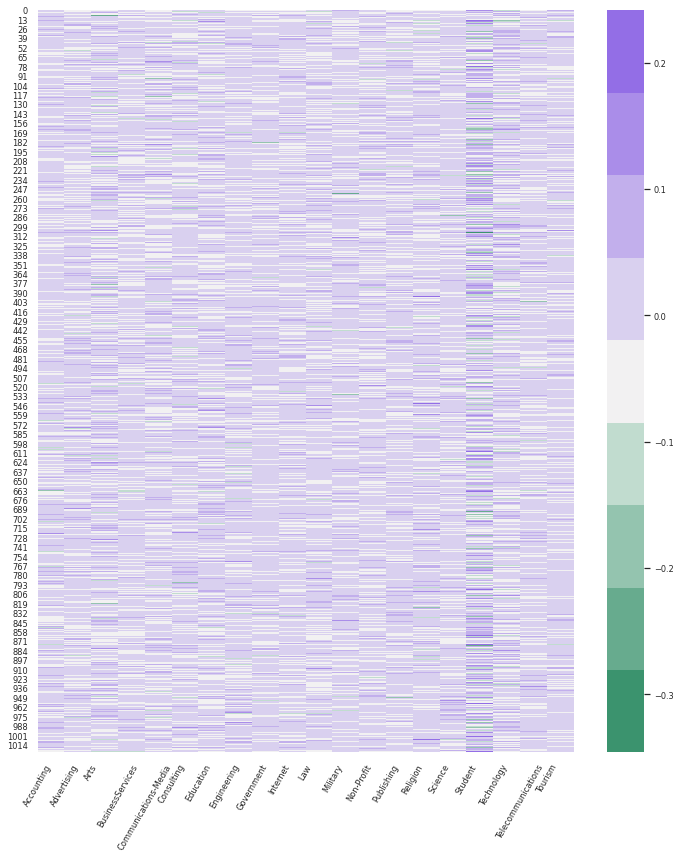

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelBinarizer
#numpy.cov(np.stack(embedding_dataset.embedding.tolist()), y=None, rowvar=False)
candidates = embedding_dataset[embedding_dataset.topic.isin(embedding_dataset.topic.value_counts()[1:21].index.tolist())]
mlb = LabelBinarizer()
y = mlb.fit_transform(candidates.topic.astype(str).tolist())
x = np.stack(candidates.embedding.tolist())

corr = np.zeros((x.shape[-1], y.shape[-1]))
sns.set(font_scale = .75)

for i, x_var in enumerate(x.T):
    for j, y_var in enumerate(y.T):
        corr[i, j] = np.corrcoef(x_var, y_var)[1, 0]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 12))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, cmap=cmap, square=False, linewidths=0)#, cbar_kws={"shrink": .5})
ax.set_xticks(range(len(mlb.classes_)), mlb.classes_, rotation = 60)
f.tight_layout()
plt.savefig("figures/blog_occupationcorr.pdf", dpi=1000)
plt.show()


[[-0.09140546]
 [ 0.16898297]
 [ 0.03707717]
 ...
 [ 0.04738646]
 [ 0.04651115]
 [ 0.19500066]]


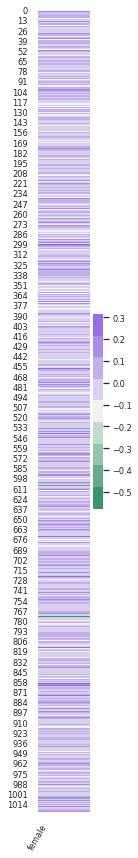

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelBinarizer
#numpy.cov(np.stack(embedding_dataset.embedding.tolist()), y=None, rowvar=False)
candidates = embedding_dataset
mlb = LabelBinarizer()
y = mlb.fit_transform(candidates.gender.astype(str).tolist())
x = np.stack(candidates.embedding.tolist())

corr = np.zeros((x.shape[-1], y.shape[-1]))
sns.set(font_scale = .75)

for i, x_var in enumerate(x.T):
    for j, y_var in enumerate(y.T):
        corr[i, j] = np.corrcoef(x_var, y_var)[1, 0]

print(corr)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(2, 12))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, cmap=cmap, square=False, linewidths=0)#, cbar_kws={"shrink": .5})
ax.set_xticks([0], [mlb.classes_[0]], rotation = 60)
f.tight_layout()
plt.savefig("figures/blog_gendercorr.pdf", dpi=1000)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

def plot_df(df):
    %matplotlib inline

    plt.figure(figsize=(12, 8.5))
    
    sns.set_style("whitegrid")

    ax = sns.scatterplot(x='umap_0', # Horizontal axis
               y='umap_1', # Vertical axis
               data=df, # Data source
               s=250) # size and dimension

    #plt.title('NLI')
    # Set x-axis label
    plt.xlabel('Component 1')
    # Set y-axis label
    plt.ylabel('Component 2')
    for line in range(0,df.shape[0]):
        plt.text(df.umap_0[line]+0.2, df.umap_1[line], df.Job[line], horizontalalignment='left', size='medium', color='black', weight='semibold')   

    return plt
    
def make_plot(data, n_neighbors, min_dist):
    scaler = StandardScaler()
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine',
                        random_state=0)
    embeddings_train = data.tolist()
    scaled_embs = scaler.fit_transform(embeddings_train)
    reduced_embs = reducer.fit_transform(scaled_embs)
    
    df = pd.DataFrame({'umap_0': reduced_embs[:,0],
                   'umap_1': reduced_embs[:,1],
                   'Job': data.index.tolist(),
                  })
    print(f'n_neighbors:{n_neighbors}, min_dist:{min_dist}')
    
    return plot_df(df)

neighbors = [3, 5, 10, 20]
min_dist = [.1, .25, .5, .75, .9, .99]
params = [{'n_neighbors': nn, 'min_dist': md} for nn in neighbors for md in min_dist]
candidates = embedding_dataset[embedding_dataset.topic.isin(embedding_dataset.topic.value_counts()[2:12].index.tolist())]
#[make_plot(candidates, **kwparams) for kwparams in params]

n_neighbors:3, min_dist:0.5


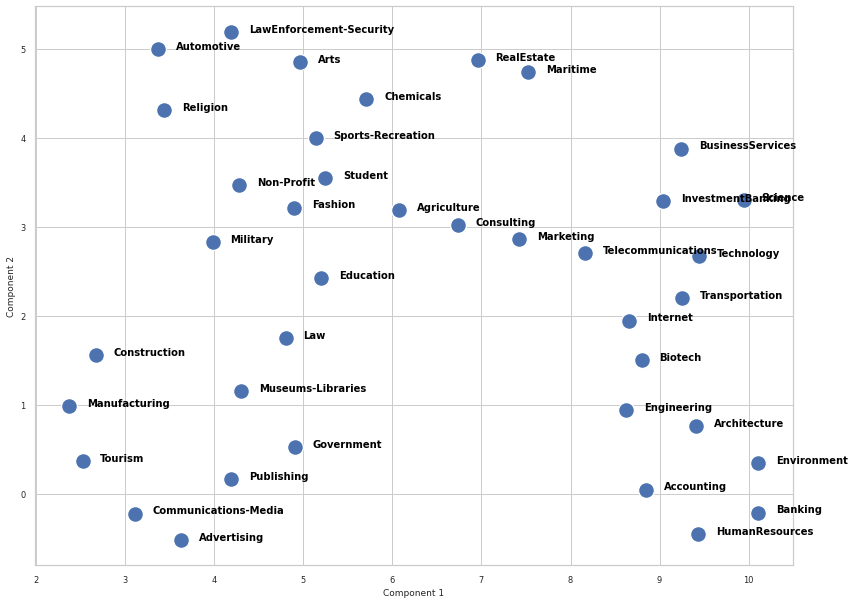

In [21]:
plt = make_plot(job_df[:-1], n_neighbors=3, min_dist=.5)
plt.tight_layout()
plt.savefig("figures/blog_occupation.pdf", dpi=1000)

In [22]:
age_df = embedding_dataset.groupby('age').apply(lambda x: np.stack(x.embedding.values).mean(0))
age_df

age
13    [0.10785355, -0.057470903, 0.2286404, 0.000844...
14    [0.06108721, -0.028753513, 0.23047632, 0.00107...
15    [0.04814981, -0.034195393, 0.23402804, 0.00131...
16    [0.05125221, -0.03720269, 0.22263967, 0.001246...
17    [0.033504874, -0.040937852, 0.1805933, 0.00096...
23    [0.008060966, -0.057615705, 0.18033092, 0.0008...
24    [0.0053248787, -0.047633156, 0.1716844, 0.0010...
25    [0.0027042325, -0.059459902, 0.18213083, 0.000...
26    [0.0031970064, -0.04726328, 0.14308217, 0.0006...
27    [0.0050220126, -0.05180317, 0.19549823, 0.0006...
33    [0.0007355268, -0.0773723, 0.19991343, 0.00085...
34    [0.0038098455, -0.07428297, 0.13881083, 0.0005...
35    [0.0023346646, -0.03452384, 0.15933165, 0.0004...
36    [0.0010886418, -0.06866051, 0.17895725, 0.0004...
37    [0.0005479365, -0.043160923, 0.1912887, 0.0008...
38    [0.0029871655, -0.095985435, 0.23801751, 0.000...
39    [0.00042912303, -0.05978452, 0.119052514, 0.00...
40    [0.0013210217, -0.09314833, 0.13095254

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

def plot_df(df):
    %matplotlib inline

    plt.figure(figsize=(7,4.5))
    
    sns.set_style("whitegrid")

    ax = sns.scatterplot(x='umap_0', # Horizontal axis
               y='umap_1', # Vertical axis
               data=df, # Data source
               alpha=0.25,
               s=250) # size and dimension

    #plt.title('NLI')
    # Set x-axis label
    plt.xlabel('Component 1')
    # Set y-axis label
    plt.ylabel('Component 2')
    for line in range(0,df.shape[0]):
        plt.text(df.umap_0[line]+0.2, df.umap_1[line], df.Age[line], horizontalalignment='left', size='medium', color='black', weight='semibold')   

    return plt
    
def make_plot(data, n_neighbors, min_dist):
    scaler = StandardScaler()
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine',
                        random_state=0)
    embeddings_train = data.tolist()
    scaled_embs = scaler.fit_transform(embeddings_train)
    reduced_embs = reducer.fit_transform(scaled_embs)
    
    df = pd.DataFrame({'umap_0': reduced_embs[:,0],
                   'umap_1': reduced_embs[:,1],
                   'Age': data.index.tolist(),
                  })
    print(f'n_neighbors:{n_neighbors}, min_dist:{min_dist}')
    
    return plot_df(df)

candidates = embedding_dataset[embedding_dataset.topic.isin(embedding_dataset.topic.value_counts()[2:12].index.tolist())]

n_neighbors:3, min_dist:0.1


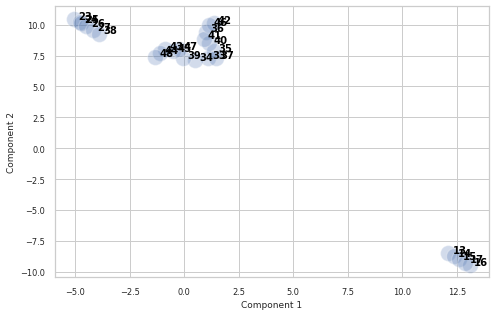

In [24]:
plt = make_plot(age_df, n_neighbors=3, min_dist=.1)
plt.tight_layout()
plt.savefig("figures/blog_age.pdf", dpi=1000)

In [25]:
embeddings = []

for book_idx, book_df in tqdm(data_zoo['mails'].groupby('id')):
    with torch.no_grad():
        batch = TOKENIZER(book_df.decoded_text.tolist(), return_tensors='pt', padding=True, max_length=512, truncation=True)
        embedding = model(batch.input_ids[:128].cuda(model.device), batch.attention_mask[:128].cuda(model.device))
        embeddings.append(embedding.cpu().numpy())


  0%|          | 0/15 [00:00<?, ?it/s]

In [26]:
import re

grouped_df = data_zoo['mails'].groupby('id')
author_id =  grouped_df.apply(lambda x: x.iloc[0]).index.tolist()
sample_text =  grouped_df.apply(lambda x: x.iloc[1]).decoded_text.tolist()

embedding_full_dataset = pd.DataFrame({'embedding': embeddings, 'mean_embedding': [embed.mean(0) for embed in embeddings], 'author': author_id, 'text_example':sample_text})
embedding_full_dataset

,embedding,mean_embedding,author,text_example
0,"[[0.03297715, -0.00010403648, 0.010752872, 0.0...","[0.007317514, -0.002523814, 0.045751642, 0.006...",mail_1,Room.\n* JEFF: Breakout charges were for (2) ...
1,"[[0.002534009, -1.787567e-05, 0.03502529, 9.98...","[0.0037649735, -0.0011105726, 0.080825455, 0.0...",mail_102,if you were around for lunch today. Give me ...
2,"[[0.04680615, -4.41966e-05, 0.014654607, 0.000...","[0.024982464, -0.0028133201, 0.069620974, 0.00...",mail_105,Methodology\nAttached is the proposed ERCOT I...
3,"[[0.108891115, -2.6438911e-05, 0.024101837, 0....","[0.004496966, -0.0017537366, 0.039745405, 0.00...",mail_116,"lawner@enron.com, linda.noske@enron.com, \n\tl..."
4,"[[0.021869307, -5.7348636e-05, 0.059568334, 0....","[0.027693162, -0.0017071692, 0.10280679, 0.003...",mail_2,:06 PM\nTo: Amy Spoede/HOU/ECT@ECT\ncc: \nSub...
5,"[[0.027430255, -0.004435153, 0.050984815, 0.00...","[0.007434112, -0.010707707, 0.03672565, 0.0045...",mail_24,credit quality of Wisconsin Electric Power Co...
6,"[[0.01979183, -0.00074963266, 0.021063266, 1.3...","[0.021752395, -0.0014516955, 0.052493073, 0.00...",mail_31,"com, peter.makkai@enron.com, \n\tmauricio.marq..."
7,"[[0.033659063, -0.0017890851, 0.08996072, 0.00...","[0.008218319, -0.00171106, 0.067261375, 0.0026...",mail_43,"/2001 07:23 AM\n\t\nTo: <bhueter@enron.com>, <..."
8,"[[0.00037294638, -0.00027761448, 0.020097723, ...","[0.009131622, -0.0050915303, 0.034144964, 0.00...",mail_53,Buckey and others. The wells are \ndescribed...
9,"[[0.00083206856, -0.00018286351, 0.015670061, ...","[0.0035701545, -0.0038036543, 0.052838385, 0.0...",mail_55,ECT on 01/12/2001 \n04:07 PM -----------------...


In [27]:
embeds = np.stack(embedding_dataset.embedding.values)

<AxesSubplot:>

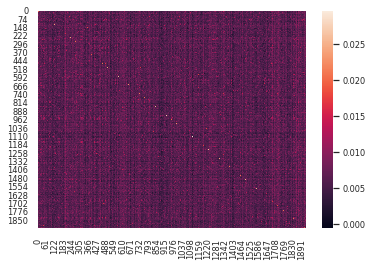

In [28]:
from numpy.linalg import norm

cosine = np.dot(embeds, embeds.T)/(norm(embeds, axis=1)*norm(embeds))

sns.heatmap(cosine)

<AxesSubplot:>

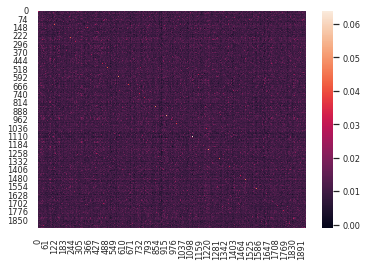

In [29]:
covariance = np.cov(embeds)
sns.heatmap(covariance)

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

def plot_df(df, df_ref):
    %matplotlib inline

    plt.figure(figsize=(10,7.5))
    
    sns.set_style("whitegrid")

    ax = sns.scatterplot(x='umap_0', # Horizontal axis
                         y='umap_1', # Vertical axis
                         data=df, # Data source
                         hue='Author', # Color by
                         palette="Spectral",
                         s=25) # size and dimension
    ax = sns.scatterplot(x='umap_0', # Horizontal axis
                         y='umap_1', # Vertical axis
                         data=df_ref, # Data source
                         palette="Spectral",
                         hue='Author', # Color by
                         marker='X', # Marker
                         edgecolor='k',
                         legend=False,
                         s=200) # size and dimension

    #plt.title('NLI')
    # Set x-axis label
    plt.xlabel('Component 1')
    # Set y-axis label
    plt.ylabel('Component 2')

    legend = plt.legend(fancybox = True)

    return plt
    
def make_plot(data, n_neighbors, min_dist):
    scaler = StandardScaler()
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine',
                        random_state=0)
    embeddings_train = data.embedding.tolist()
    scaled_embs = scaler.fit_transform(np.concatenate(embeddings_train))
    reduced_embs = reducer.fit_transform(scaled_embs)

    embeddings_ref = data.mean_embedding.tolist()
    scaled_ref = scaler.transform(embeddings_ref)
    reduced_ref = reducer.transform(scaled_ref)
    
    author_to_id = {author: idx for idx, author in enumerate(data.author.unique())}
    author_id = [author_to_id[author] for author in data.author]

    df = pd.DataFrame({'umap_0': reduced_embs[:,0],
                       'umap_1': reduced_embs[:,1],
                       'Author': np.repeat(author_id, 128),
                       })
    df_ref = pd.DataFrame({'umap_0': reduced_ref[:,0],
                            'umap_1': reduced_ref[:,1],
                            'Author': author_id,
                            })
                            
    print(f'n_neighbors:{n_neighbors}, min_dist:{min_dist}')
    
    return plot_df(df, df_ref)

n_neighbors:25, min_dist:0.5


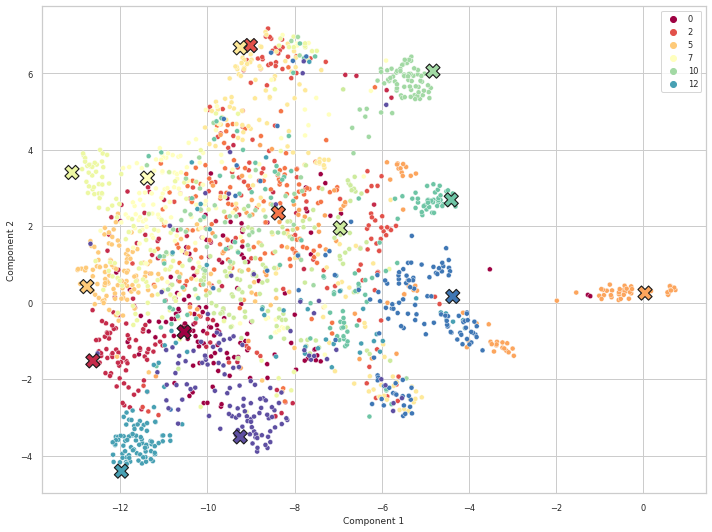

In [31]:
plt = make_plot(embedding_full_dataset, n_neighbors=25, min_dist=.5)
plt.tight_layout()
plt.savefig("figures/mails_umap.pdf", dpi=1000)